In [1]:
import numpy as np
import os,re
import json
import h5py as h5
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

In [3]:
def DataLoader(file_name,nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        #uncomment below to add noise like caloflows does
        #data_flat +=np.random.uniform(0,1e-3,size=data_flat.shape)
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat,energy_layer).filled(0)
        return energy_layer,data_flat


    flat_energy , flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy ,shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy,energy),-1)
        flat_shower = np.concatenate((flat_shower,shower),-1)
        
    return e,flat_energy,flat_shower


file_path = '/global/home/users/haoxing_du/ToyFlow/gamma.hdf5'
energy, energy_layer, energy_voxel = DataLoader(file_path,1000)
print(energy.shape, energy_layer.shape, energy_voxel.shape)

(1000, 1) (1000, 3) (1000, 504)


(array([112., 108.,  92.,  97.,  95., 108.,  99.,  89.,  95., 105.]),
 array([ 1.2276977, 11.095776 , 20.963854 , 30.831932 , 40.70001  ,
        50.56809  , 60.436165 , 70.304245 , 80.172325 , 90.0404   ,
        99.90848  ], dtype=float32),
 <BarContainer object of 10 artists>)

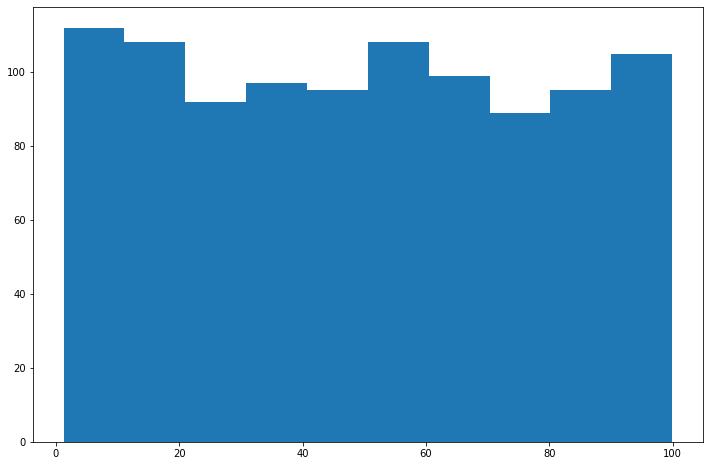

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

# histogram of energies
plt.hist(energy)

In [5]:
layer0 = [x[0] for x in energy_layer]
layer0 = np.array(layer0)

layer1 = [x[1] for x in energy_layer]
layer1 = np.array(layer1)

layer2 = [x[2] for x in energy_layer]
layer2 = np.array(layer2)

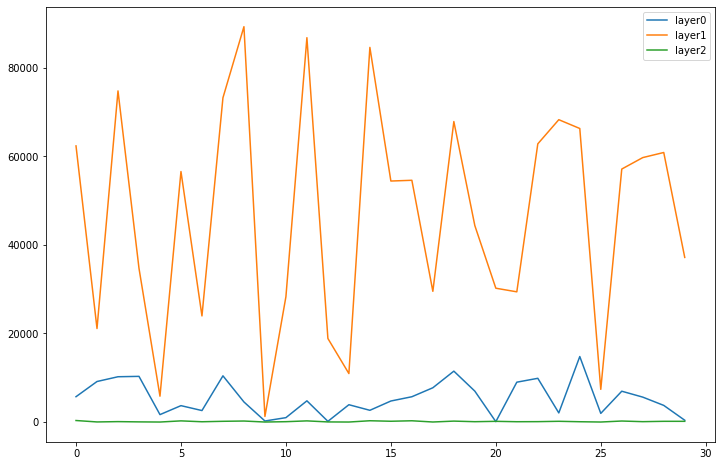

In [6]:
# Plot the energy in each layer for the first 30 entries
plt.plot(layer0[:30],label='layer0')
plt.plot(layer1[:30],label='layer1')
plt.plot(layer2[:30],label='layer2')
plt.legend()

In [7]:
#print(f"Particle energy: {energy[0][0] * 1000} MeV")
#print(f"Layer 0 energy: {layer0[0]} MeV")
#print(f"Layer 1 energy: {layer1[0]} MeV")
#print(f"Layer 2 energy: {layer2[0]} MeV")
#print(f"Difference (true - total): {energy[0][0]*1000-layer0[0]-layer1[0]-layer2[0]} MeV")

# Let's look at a random data point

i = np.random.randint(1000)

print(f"True particle energy: {energy[i][0] * 1000} MeV")
print(f"Layer 0 energy: {layer0[i]} MeV")
print(f"Layer 1 energy: {layer1[i]} MeV")
print(f"Layer 2 energy: {layer2[i]} MeV")
print(f"Difference (true - total): {energy[i][0]*1000-layer0[i]-layer1[i]-layer2[i]} MeV")

True particle energy: 57566.46728515625 MeV
Layer 0 energy: 3564.494873046875 MeV
Layer 1 energy: 53379.55078125 MeV
Layer 2 energy: 130.14178466796875 MeV
Difference (true - total): 492.27984619140625 MeV


In [8]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [12]:
samples = np.concatenate([energy_layer, energy*1000],-1)
samples = samples / 10000
samples

array([[5.7252860e-01, 6.2348557e+00, 3.4686863e-02, 6.8921399e+00],
       [9.1534442e-01, 2.1117783e+00, 2.3759564e-03, 3.0485311e+00],
       [1.0229657e+00, 7.4766531e+00, 9.7022122e-03, 8.5592804e+00],
       ...,
       [8.4607929e-01, 3.9282672e+00, 8.2227401e-03, 4.8173881e+00],
       [8.0483067e-01, 5.6593194e+00, 7.4642301e-02, 6.6087728e+00],
       [1.3440652e+00, 5.0776148e+00, 4.2587556e-03, 6.4499536e+00]],
      dtype=float32)

In [17]:
LR = 1e-3
NUM_EPOCHS = 60
STACKED_FFJORDS = 1 #Number of stacked transformations
NUM_LAYERS = 8 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 4*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

DATASET_SIZE = 1000
BATCH_SIZE = 50

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='loss',patience=10,restore_best_weights=True),
]
    
#Create the model
model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

history = model.fit(
    samples,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/60
20/20 [==============================] - 21s 38ms/step - loss: 14.6775
Epoch 2/60
20/20 [==============================] - 1s 60ms/step - loss: 10.8499
Epoch 3/60
20/20 [==============================] - 1s 68ms/step - loss: 8.5444
Epoch 4/60
20/20 [==============================] - 2s 76ms/step - loss: 7.2073
Epoch 5/60
20/20 [==============================] - 2s 84ms/step - loss: 6.4335
Epoch 6/60
20/20 [==============================] - 2s 85ms/step - loss: 5.7155
Epoch 7/60
20/20 [==============================] - 2s 101ms/step - loss: 5.2103
Epoch 8/60
20/20 [==============================] - 2s 98ms/step - loss: 4.6678
Epoch 9/60
20/20 [==============================] - 2s 118ms/step - loss: 3.9366
Epoch 10/60
20/20 [==============================] - 2s 114ms/step - loss: 3.6913
Epoch 11/60
20/20 [==============================] - 2s 110ms/step - loss: 3.5214
Epoch 12/60
20/20 [==============================] - 2s 114ms/step - loss: 3.1315
Epoch 13/60
20/20 [==========

In [18]:
NSAMPLES = DATASET_SIZE

#Sample the learned distribution
transformed = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': energy}})
)

transformed_first = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.ones((NSAMPLES,1),dtype=np.float32)}})
)

transformed_second = model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        model.flow.bijector, {'bijector.': {'conditional_input': np.zeros((NSAMPLES,1),dtype=np.float32)}})
)

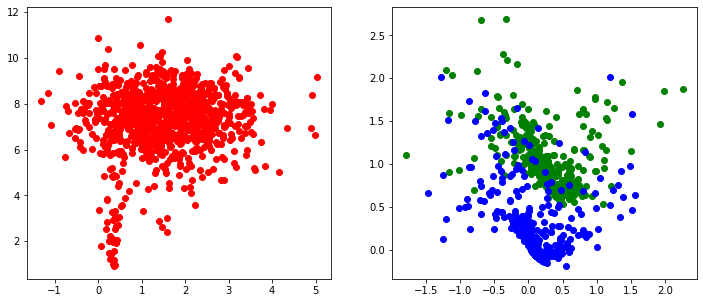

In [19]:
#Plotting    
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)    
plt.scatter(transformed[:, 0], transformed[:, 1], color="r")
plt.subplot(122)
plt.scatter(transformed_first[:, 0], transformed_first[:, 1], color="g")
plt.scatter(transformed_second[:, 0], transformed_second[:, 1], color="b")

In [20]:
transformed

<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
array([[ 0.42820597,  8.344135  , -0.577061  ],
       [ 1.9288813 ,  5.8851643 ,  0.12171434],
       [ 2.6510298 ,  7.5146756 , -0.6348323 ],
       ...,
       [ 1.0020661 ,  7.199344  ,  1.1891785 ],
       [ 1.3534328 ,  7.39959   , -0.6911607 ],
       [ 3.2392633 ,  9.135859  ,  0.013552  ]], dtype=float32)>

In [22]:
energy_layer/1

array([[5.7252861e+03, 6.2348555e+04, 3.4686865e+02],
       [9.1534443e+03, 2.1117783e+04, 2.3759563e+01],
       [1.0229656e+04, 7.4766531e+04, 9.7022125e+01],
       ...,
       [8.4607930e+03, 3.9282672e+04, 8.2227402e+01],
       [8.0483066e+03, 5.6593195e+04, 7.4642297e+02],
       [1.3440652e+04, 5.0776148e+04, 4.2587555e+01]], dtype=float32)